In [1]:
# Standard libraries
import os
import tempfile
import time
import io
import random
import math
import warnings
from multiprocessing import Manager
from typing import Optional

# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, random_split

# MONAI libraries
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Other medical image processing libraries
import SimpleITK as sitk
import torchio as tio

# Plotting and visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# Custom modules
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet_2Q
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train,Eval






config = {
    'batch_size': 4,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 0, 
    'perc_high': 100,
    'rescaleFactor':2,
    'base_path': '',
}

# %%


imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_test = './Data/splits/IXI_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    var_csv[state]['seg_path'] =  var_csv[state]['mask_path']


data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

/home1/akrami/.conda/envs/working_monai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-10-02 07:55:05,591 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
2023-10-02 07:55:07,878 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: hale-akrami (usc_akrami). Use `wandb login --relogin` to force relogin


In [3]:

model = DiffusionModelUNet_2Q(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)

model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)


scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)
inferer = DiffusionInferer(scheduler)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)
scaler = GradScaler()


Using 2 GPUs!


In [4]:
# specify your model filename
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/3Q/model_epoch1298.pt'
model.load_state_dict(torch.load(model_filename))
model.eval()

DataParallel(
  (module): DiffusionModelUNet_2Q(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
    

In [5]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])
print(sub_test['vol']['data'].size())


dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([38.9000, 58.6600, 32.9400, 58.2800], dtype=torch.float64)
torch.Size([4, 1, 80, 96, 80])


In [65]:

# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
peak_expanded = peak_expanded.to(device)

# Perform the division
image_array = (image_array / peak_expanded)
middle_slice_idx = int(image_array.size(-1) // 2)
# image_array = image_array

In [66]:
import numpy as np

def generate_gaussian_blob(size, sigma):
    """
    Generate a 3D Gaussian blob.
    
    Parameters:
    - size: a tuple of (depth, height, width) representing the size of the blob.
    - sigma: standard deviation for the Gaussian function.
    
    Returns:
    - A 3D numpy array representing the Gaussian blob.
    """
    z, y, x = np.meshgrid(np.linspace(-1,1,size[0]), np.linspace(-1,1,size[1]), np.linspace(-1,1,size[2]))
    d = np.sqrt(x*x + y*y + z*z)
    g = np.exp(-( (d)**2 / ( 2.0 * sigma**2 ) ))
    return g

In [67]:
import torch

def random_lesion_params(image_shape):
    """
    Generate random lesion size and location based on the image shape.
    
    Parameters:
    - image_shape: a tuple of (channels, depth, height, width) representing the size of the image.
    
    Returns:
    - lesion_size: a tuple representing the size of the lesion.
    - start_location: a tuple representing the start location of the lesion in the image.
    """
    _, D, H, W = image_shape
    max_size = min(D, H, W)
    
    lesion_depth = torch.randint(1, max_size + 1, (1,)).item()
    lesion_height = torch.randint(1, max_size + 1, (1,)).item()
    lesion_width = torch.randint(1, max_size + 1, (1,)).item()
    
    lesion_size = (lesion_depth, lesion_height, lesion_width)
    
    start_d = torch.randint(0, D - lesion_depth + 1, (1,)).item()
    start_h = torch.randint(0, H - lesion_height + 1, (1,)).item()
    start_w = torch.randint(0, W - lesion_width + 1, (1,)).item()
    
    start_location = (start_d, start_h, start_w)
    
    return lesion_size, start_location


In [68]:
sub_tensor_size = image_array[i, 0, 
                              start_location[0]:start_location[0]+lesion_size[0], 
                              start_location[1]:start_location[1]+lesion_size[1], 
                              start_location[2]:start_location[2]+lesion_size[2]].shape
print("Sub-tensor size:", sub_tensor_size)
print("Blob tensor size:", blob_tensor.shape)


Sub-tensor size: torch.Size([8, 44, 25])
Blob tensor size: torch.Size([8, 44, 25])


In [72]:

i=1
lesion_size, start_location = random_lesion_params(image_array[i].shape)
print(start_location)

blob = generate_gaussian_blob(lesion_size, sigma=0.5)
threshold = 0.7
blob[blob < threshold] = 0

# Convert the blob (NumPy array) to a PyTorch tensor and move it to the same device as image_array
blob_tensor = torch.tensor(blob, device=image_array.device, dtype=image_array.dtype)
# Transpose the depth and height dimensions of the blob_tensor
blob_tensor = blob_tensor.permute(1, 0, 2)

# Add the blob_tensor to the image_array
image_array[i, 0, 
            start_location[0]:start_location[0]+lesion_size[0], 
            start_location[1]:start_location[1]+lesion_size[1], 
            start_location[2]:start_location[2]+lesion_size[2]] -= blob_tensor



(15, 4, 24)


In [73]:
import matplotlib.pyplot as plt

# Get the middle slice of the blob
#middle_slice_idx = blob_tensor.shape[0] // 2
blob_slice = blob_tensor[middle_slice_idx].cpu().numpy()

plt.figure(figsize=(2, 2))
plt.imshow(blob_slice, cmap="gray")
plt.title("Middle Slice of the Blob")
plt.axis("off")
plt.show()


IndexError: index 40 is out of bounds for dimension 0 with size 29

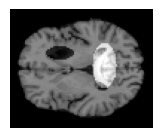

In [74]:

plt.figure(figsize=(2, 2))
plt.imshow(image_array[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [75]:
noise = torch.randn_like(image_array).to(device)
timesteps = torch.randint(299, 300, (image_array.shape[0],), device=image_array.device).long()
prediction,prediction_m,prediction_h = inferer(inputs=image_array, diffusion_model=model, noise=noise, timesteps=timesteps)

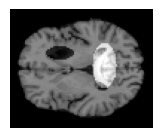

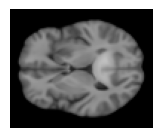

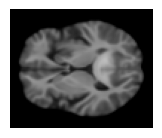

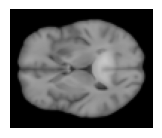

In [77]:

i=1
plt.figure(figsize=(2, 2))
plt.imshow(image_array[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_m[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(prediction[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_h[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

        

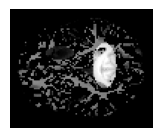

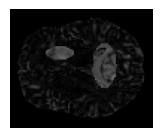

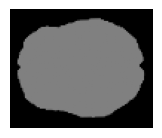

In [78]:
segmented = image_array * ((image_array < prediction) | (image_array > prediction_h)).float()
segmented = segmented*(image_array>0.001)
error = torch.abs(image_array-prediction_m)

middle_slice_idx = int(image_array.size(-1) // 2)

plt.figure(figsize=(2, 2))
plt.imshow(segmented[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(error[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(sub_test['seg']['data'][i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()




        

In [13]:
f"/scratch1/akrami/models/3Ddiffusion/half_norm/model_epoch{epoch}.pt"
f"./results/half_norm/sample_epoch{epoch}.png"

NameError: name 'epoch' is not defined